# IEEE-CIS Fraud Detection
## Can you detect fraud from customer transactions?
*Visit [kaggle](https://www.kaggle.com/c/ieee-fraud-detection) for competition details*

**Authored by Soyoung Kang**

## Columns
- 'TransactionID'
- 'isFraud'
- 'TransactionDT'
- 'TransactionAmt'
- 'card1'
- 'TransactionAmt_residue'
- 'repeated'
- 'ProductCD_C'
- 'ProductCD_H'
- 'ProductCD_R'
- 'ProductCD_S'
- 'ProductCD_W'
- 'card2_na'
- 'card3_ran'
- 'card3_fraud_ratio'
- 'card4_ran'
- 'card5_ran'
- 'card5_fraud_ratio'
- 'card6_fraud_ratio'
- 'addr1_na'
- 'addr2_ran'
- 'addr2_fraud_ratio'
- 'dist1_na'
- 'dist2_na'
- 'C1_fraud_ratio'
- 'C2_fraud_ratio'
- 'C3_fraud_ratio'
- 'C4_fraud_ratio'
- 'C5_fraud_ratio'
- 'C6_fraud_ratio'
- 'C7_fraud_ratio'
- 'C8_fraud_ratio'
- 'C9_fraud_ratio'
- 'C10_fraud_ratio'
- 'C11_fraud_ratio'
- 'C12_fraud_ratio'
- 'C13_fraud_ratio'
- 'C14_fraud_ratio'
- 'C_pca1'
- 'C_pca2'

### Newly added columns
- 'TransactionAmt_residue'
- 'repeated'
- Dummy columns for ProductCD (dropped 'ProductCD')
- 'card2_na' (dropped 'card2')
- 'card3_ran' (dropped 'card3')
- 'card3_fraud_ratio'
- 'card4_ran' (dropped 'card4')
- 'card5_ran' (dropped 'card5')
- 'card5_fraud_ratio'
- 'card6_fraud_ratio' (based on random sampling-imputed 'card6', dropped 'card6' and 'card6_ran')
- 'addr1_na' (dropped 'addr1')
- 'addr2_ran' (dropped 'addr2')
- 'addr2_fraud_ratio'
- 'dist1_na' (dropped 'dist1')
- 'dist2_na' (dropped 'dist2')
- 'C\*\_fraud_ratio' (dropped 'C\*')
- 'C_pca1', 'C_pca2'

### Dropped columns
- Dropped P_emaildomain, R_emaildomain

In [2]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

In [3]:
trns_train = pd.read_csv('../ieee-fraud-detection/train_transaction.csv', engine = 'python')

# 1. TransactionAmt
- 소숫점 이하 자릿수 15자리 이상 여부에 대한 boolean 컬럼 생성.
- 반복 거래(card1~6정보와 TransactionAmt, ProductCD가 일치하는 거래)에 대해 'repeated' 컬럼 생성.
    * value: 해당 카드의 전체 거래건수 대비 반복 거래 비율

## 소숫점 이하 자릿수 15자리 이상 여부에 대한 boolean 컬럼 생성.
***Add a boolean column 'TransactionAmt_residue' indicating whether TransactionAmt value exceeds 15 digits after decimal point.***

In [4]:
def num_after_point(x):
    s = str(x)
    if not '.' in s:
        return 0
    return len(s) - s.index('.') - 1 

trns_train['TransactionAmt_residue'] = ''

for index, row in trns_train.iterrows():
    r = num_after_point(row['TransactionAmt'])
    if r >= 15:
        trns_train.at[index, 'TransactionAmt_residue'] = 1
    else:
        trns_train.at[index, 'TransactionAmt_residue'] = 0

## 반복 거래(card1~6정보와 TransactionAmt, ProductCD가 일치하는 거래)에 대해 'repeated' 컬럼 생성.
***Add a column called 'repeated' storing ratios of repeated transactions to the total transactions per each card.***
- value: 해당 카드의 전체 거래건수 대비 반복 거래 비율

In [4]:
trns_train['card_merged'] = trns_train[['card1', 'card2', 'card3', 'card4', 'card5', 'card6']].astype(str).apply(lambda x : ' '.join(x), axis = 1)

In [6]:
trns_fraud = trns_train[trns_train.isFraud == 1]
trns_nonfraud = trns_train[trns_train.isFraud == 0]

In [5]:
trns_train['transaction_temp'] = trns_train[['TransactionAmt', 'ProductCD', 'card_merged']].astype(str).apply(lambda x : ' '.join(x), axis = 1)

In [7]:
# {repeated_transaction : repeated times}
d = trns_train.groupby(['transaction_temp'])['TransactionID'].count().to_dict()
d

{'0.251 C 4480 366.0 162.0 visa 166.0 debit': 1,
 '0.272 C 1903 555.0 146.0 mastercard 224.0 credit': 1,
 '0.292 C 15885 545.0 185.0 visa 138.0 debit': 5,
 '0.35 C 15885 545.0 185.0 visa 138.0 debit': 1,
 '0.364 C 3489 277.0 144.0 visa 226.0 credit': 1,
 '0.424 C 12616 490.0 150.0 visa nan credit': 4,
 '0.467 C 12616 490.0 150.0 visa nan credit': 1,
 '0.467 C 15885 545.0 185.0 visa 138.0 debit': 3,
 '0.467 C 3154 408.0 185.0 mastercard 224.0 debit': 2,
 '0.484 C 12616 490.0 150.0 visa nan credit': 1,
 '0.498 C 15885 545.0 185.0 visa 138.0 debit': 1,
 '0.499 C 14381 555.0 180.0 visa 226.0 debit': 1,
 '0.5429999999999999 C 1903 555.0 146.0 mastercard 224.0 credit': 1,
 '0.57 C 8746 555.0 223.0 visa 102.0 debit': 1,
 '0.583 C 12616 490.0 150.0 visa nan credit': 2,
 '0.583 C 15885 545.0 185.0 visa 138.0 debit': 1,
 '0.583 C 9026 545.0 185.0 visa 137.0 credit': 2,
 '0.588 C 3154 408.0 185.0 mastercard 224.0 debit': 1,
 '0.615 C 10911 nan 150.0 visa nan credit': 2,
 '0.615 C 13832 375.0 185.

In [8]:
trns_train['repeated'] = trns_train['transaction_temp'].map(d)

In [9]:
trns_train[['transaction_temp', 'repeated']]

,transaction_temp,repeated
0,68.5 W 13926 nan 150.0 discover 142.0 credit,1
1,29.0 W 2755 404.0 150.0 mastercard 102.0 credit,8
2,59.0 W 4663 490.0 150.0 visa 166.0 debit,87
3,50.0 W 18132 567.0 150.0 mastercard 117.0 debit,17
4,50.0 H 4497 514.0 150.0 mastercard 102.0 credit,2
5,49.0 W 5937 555.0 150.0 visa 226.0 debit,3
6,159.0 W 12308 360.0 150.0 visa 166.0 debit,1
7,422.5 W 12695 490.0 150.0 visa 226.0 debit,5
8,15.0 H 2803 100.0 150.0 visa 226.0 debit,13
9,117.0 W 17399 111.0 150.0 mastercard 224.0 debit,99


In [9]:
trns_train.drop(columns = ['transaction_temp', 'card_merged'], inplace = True)

In [10]:
trns_train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339',
       'repeated'],
      dtype='object', length=395)

# 2. ProductCD
- dummy columns 생성.

In [22]:
trns_dum = pd.get_dummies(trns_train, columns = ['ProductCD'])

# 3. card1
- Nothing to do.

# 4. card2
- imputation: card2_na 컬럼 생성.

In [14]:
trns_dum['card2_na'] = np.where(trns_dum.card2.isnull(), 1, 0)
trns_dum.drop('card2', axis = 1, inplace = True)

# 5. card3
- 국가 정보라는 가정.
- imputation: random sampling
- card5 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.

## Imputation: Random Sampling

In [4]:
trns_dum['card3_ran'] = trns_dum['card3']
temp = (trns_dum['card3'].dropna().sample(trns_dum['card3'].isnull().sum()))
temp.index = trns_dum[lambda x: x.card3.isnull()].index
trns_dum.loc[trns_dum['card3'].isnull(), 'card3_ran'] = temp

trns_dum.drop('card3', axis = 1, inplace = True)

## card3 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.
***Add column 'card3_fraud_ratio' indicating the ratio of fraud transactions per card3 value.***

In [18]:
s0 = trns_dum.groupby(['card3_ran'])['isFraud'].count()
s1 = trns_dum.groupby(['card3_ran'])['isFraud'].sum()
s2 = trns_dum.groupby(['card3_ran'])['isFraud'].sum() / trns_dum.groupby(['card3_ran'])['isFraud'].count()

df = pd.DataFrame(columns = ['transaction_num','fraud_num', 'fraud_ratio'])
df['transaction_num'] = s0
df['fraud_num'] = s1
df['fraud_ratio'] = s2

df_dic = df['fraud_ratio'].to_dict()
trns_dum['card3_fraud_ratio'] = trns_dum['card3_ran'].map(df_dic)

# 6. card4
- imputation: random sampling
- 사실상 의미 없을 것으로 예상.

In [16]:
trns_dum['card4_ran'] = trns_dum['card4']
temp = (trns_dum['card4'].dropna().sample(trns_dum['card4'].isnull().sum()))
temp.index = trns_dum[lambda x: x.card4.isnull()].index
trns_dum.loc[trns_dum['card4'].isnull(), 'card4_ran'] = temp

trns_dum.drop('card4', axis = 1, inplace = True)

# 7. card5
- imputation: random sampling
- card5 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.

## Imputation: Random Sampling

In [17]:
trns_dum['card5_ran'] = trns_dum['card5']
temp = (trns_dum['card5'].dropna().sample(trns_dum['card5'].isnull().sum()))
temp.index = trns_dum[lambda x: x.card5.isnull()].index
trns_dum.loc[trns_dum['card5'].isnull(), 'card5_ran'] = temp

trns_dum.drop('card5', axis = 1, inplace = True)

## card5 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.
***Add column 'card5_fraud_ratio' indicating the ratio of fraud transactions per card5 value.***

In [18]:
s0 = trns_dum.groupby(['card5_ran'])['isFraud'].count()
s1 = trns_dum.groupby(['card5_ran'])['isFraud'].sum()
s2 = trns_dum.groupby(['card5_ran'])['isFraud'].sum() / trns_dum.groupby(['card5_ran'])['isFraud'].count()

df = pd.DataFrame(columns = ['transaction_num','fraud_num', 'fraud_ratio'])
df['transaction_num'] = s0
df['fraud_num'] = s1
df['fraud_ratio'] = s2

df_dic = df['fraud_ratio'].to_dict()
trns_dum['card5_fraud_ratio'] = trns_dum['card5_ran'].map(df_dic)

# 8. card6
- imputation: random sampling
- card6 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.

## Imputation: Random Sampling

In [19]:
trns_dum['card6_ran'] = trns_dum['card6']
temp = (trns_dum['card6'].dropna().sample(trns_dum['card6'].isnull().sum()))
temp.index = trns_dum[lambda x: x.card6.isnull()].index
trns_dum.loc[trns_dum['card6'].isnull(), 'card6_ran'] = temp

trns_dum.drop('card6', axis = 1, inplace = True)

## card6 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.
***Add column 'card6_fraud_ratio' indicating the ratio of fraud transactions per card6 value.***

In [20]:
s0 = trns_dum.groupby(['card6_ran'])['isFraud'].count()
s1 = trns_dum.groupby(['card6_ran'])['isFraud'].sum()
s2 = trns_dum.groupby(['card6_ran'])['isFraud'].sum() / trns_dum.groupby(['card6_ran'])['isFraud'].count()

df = pd.DataFrame(columns = ['transaction_num','fraud_num', 'fraud_ratio'])
df['transaction_num'] = s0
df['fraud_num'] = s1
df['fraud_ratio'] = s2

df_dic = df['fraud_ratio'].to_dict()
trns_dum['card6_fraud_ratio'] = trns_dum['card6_ran'].map(df_dic)

In [ ]:
# drop card6_ran
trns_dum.drop('card6_ran', axis = 1, inplace = True)

# 9. addr1
- 지역 정보라는 가정.
- imputation: addr1_na 컬럼 생성. (nan이 오직 사기거래서만 나타남)

In [21]:
trns_dum['addr1_na'] = np.where(trns_dum.addr1.isnull(), 1, 0)
trns_dum.drop('addr1', axis = 1, inplace = True)

# 10. addr2
- 국가 정보라는 가정.
- imputation: random sampling
- addr2 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.

## Imputation: Random Sampling

In [22]:
trns_dum['addr2_ran'] = trns_dum['addr2']
temp = (trns_dum['addr2'].dropna().sample(trns_dum['addr2'].isnull().sum()))
temp.index = trns_dum[lambda x: x.addr2.isnull()].index
trns_dum.loc[trns_dum['addr2'].isnull(), 'addr2_ran'] = temp

trns_dum.drop('addr2', axis = 1, inplace = True)

## addr2 value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성.
***Add column 'addr2_fraud_ratio' indicating the ratio of fraud transactions per addr2 value.***

In [23]:
s0 = trns_dum.groupby(['addr2_ran'])['isFraud'].count()
s1 = trns_dum.groupby(['addr2_ran'])['isFraud'].sum()
s2 = trns_dum.groupby(['addr2_ran'])['isFraud'].sum() / trns_dum.groupby(['addr2_ran'])['isFraud'].count()

df = pd.DataFrame(columns = ['transaction_num','fraud_num', 'fraud_ratio'])
df['transaction_num'] = s0
df['fraud_num'] = s1
df['fraud_ratio'] = s2

df_dic = df['fraud_ratio'].to_dict()
trns_dum['addr2_fraud_ratio'] = trns_dum['addr2_ran'].map(df_dic)

# 11. dist1
- imputation: dist1_na 컬럼 생성.

In [24]:
trns_dum['dist1_na'] = np.where(trns_dum.dist1.isnull(), 1, 0)
trns_dum.drop('dist1', axis = 1, inplace = True)

# 12. dist2
- imputation: dist2_na 컬럼 생성.

In [25]:
trns_dum['dist2_na'] = np.where(trns_dum.dist2.isnull(), 1, 0)
trns_dum.drop('dist2', axis = 1, inplace = True)

# 13. P_emaildomain, R_emaildomain
- discard

In [26]:
trns_dum.drop(columns = ['P_emaildomain', 'R_emaildomain'], inplace = True)

# 14. C1~14
- 각 컬럼에 대해, value별 전체 거래 대비 사기거래 비율을 표시하는 컬럼 생성. 기존 C1~14 버림.

In [23]:
def C_fraud_ratio(i):
    s0 = trns_dum.groupby(['C' + str(i)])['isFraud'].count()
    s1 = trns_dum.groupby(['C' + str(i)])['isFraud'].sum()
    s2 = trns_dum.groupby(['C' + str(i)])['isFraud'].sum() / trns_dum.groupby(['C' + str(i)])['isFraud'].count()

    df = pd.DataFrame(columns = ['transaction_num','fraud_num', 'fraud_ratio'])
    df['transaction_num'] = s0
    df['fraud_num'] = s1
    df['fraud_ratio'] = s2

    df_dic = df['fraud_ratio'].to_dict()
    trns_dum['fraud_ratio_C' + str(i)] = trns_dum['C' + str(i)].map(df_dic)

    trns_dum.drop('C' + str(i), axis = 1, inplace = True)

In [24]:
for i in range(1, 15):
    C_fraud_ratio(i)

# 15. PCA on C1~C14_fraud_ratio 

In [41]:
c = trns_dum.iloc[:, -14:]

In [42]:
pca = PCA(n_components = 2)
pca.fit(c)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [43]:
pca.components_

array([[ 1.47516946e-01,  1.96115426e-01, -1.79074269e-04,
         4.45294438e-01,  2.91276815e-02,  9.18995580e-02,
         4.47286328e-01,  4.26127888e-01,  6.32810460e-02,
         3.44986483e-01,  1.19295800e-01,  4.57913759e-01,
         3.51016841e-02,  4.87600654e-02],
       [ 5.80806752e-01,  4.55625235e-01,  1.66071662e-03,
        -1.41644196e-01, -1.43417716e-01,  3.16236221e-01,
        -1.31795261e-01, -1.28489296e-01, -1.32016832e-01,
        -1.23982667e-01,  4.34917159e-01, -8.16619462e-02,
         1.00056543e-01,  2.04735882e-01]])

In [44]:
c_pca = pca.transform(c)
print("original shape:   ", c.shape)
print("transformed shape:", c_pca.shape)

original shape:    (590540, 14)
transformed shape: (590540, 2)


In [45]:
type(c_pca)

numpy.ndarray

In [46]:
c_pca_df = pd.DataFrame(data = c_pca, columns = ['C_pca1', 'C_pca2'])

c_pca_df.head(10)

,C_pca1,C_pca2
0,-0.032662,-0.006091
1,-0.031442,-0.018915
2,-0.034455,-0.012628
3,-0.026108,0.010789
4,-0.012795,-0.025037
5,-0.034455,-0.012628
6,-0.034455,-0.012628
7,-0.031442,-0.018915
8,-0.012795,-0.025037
9,-0.030054,-0.001411


## Merge PCA columns to dataframe

In [ ]:
trns_dum['tmp'] = 1
c_pca_df['tmp'] = 1

DF = trns_dum.merge(c_pca_df, on=['tmp'])
DF.drop('tmp', axis=1)
DF.head(10)

# Check and Trim

In [1]:
trns_dum.head(10)

NameError: name 'trns_dum' is not defined

In [73]:
list(trns_dum.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'card1',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95'

In [74]:
col = ['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'card1',
 'TransactionAmt_residue',
 'repeated',
 'ProductCD_C',
 'ProductCD_H',
 'ProductCD_R',
 'ProductCD_S',
 'ProductCD_W',
 'card2_na',
 'card3_ran',
 'card4_ran',
 'card5_ran',
 'card5_fraud_ratio',
 'card6_ran',
 'card6_fraud_ratio',
 'addr1_na',
 'addr2_ran',
 'addr2_fraud_ratio',
 'dist1_na',
 'dist2_na',
 'C1_fraud_ratio',
 'C2_fraud_ratio',
 'C3_fraud_ratio',
 'C4_fraud_ratio',
 'C5_fraud_ratio',
 'C6_fraud_ratio',
 'C7_fraud_ratio',
 'C8_fraud_ratio',
 'C9_fraud_ratio',
 'C10_fraud_ratio',
 'C11_fraud_ratio',
 'C12_fraud_ratio',
 'C13_fraud_ratio',
 'C14_fraud_ratio']

trns_preproc = trns_dum[col]

In [75]:
trns_preproc.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,TransactionAmt_residue,repeated,ProductCD_C,ProductCD_H,ProductCD_R,...,C5_fraud_ratio,C6_fraud_ratio,C7_fraud_ratio,C8_fraud_ratio,C9_fraud_ratio,C10_fraud_ratio,C11_fraud_ratio,C12_fraud_ratio,C13_fraud_ratio,C14_fraud_ratio
0,2987000,0,86400,68.5,13926,0,1,0,0,0,...,0.050369,0.027764,0.024376,0.020899,0.019062,0.021273,0.040378,0.022897,0.028304,0.026859
1,2987001,0,86401,29.0,2755,0,8,0,0,0,...,0.050369,0.027764,0.024376,0.020899,0.066683,0.021273,0.025346,0.022897,0.028304,0.026859
2,2987002,0,86469,59.0,4663,0,87,0,0,0,...,0.050369,0.027764,0.024376,0.020899,0.019062,0.021273,0.025346,0.022897,0.028304,0.026859
3,2987003,0,86499,50.0,18132,0,17,0,0,0,...,0.050369,0.053300,0.024376,0.020899,0.019062,0.021273,0.025346,0.022897,0.026178,0.026859
4,2987004,0,86506,50.0,4497,0,2,0,1,0,...,0.050369,0.027764,0.024376,0.044393,0.066683,0.046303,0.025346,0.022897,0.028304,0.026859
5,2987005,0,86510,49.0,5937,0,3,0,0,0,...,0.050369,0.027764,0.024376,0.020899,0.019062,0.021273,0.025346,0.022897,0.028304,0.026859
6,2987006,0,86522,159.0,12308,0,1,0,0,0,...,0.050369,0.027764,0.024376,0.020899,0.019062,0.021273,0.025346,0.022897,0.028304,0.026859
7,2987007,0,86529,422.5,12695,0,5,0,0,0,...,0.050369,0.027764,0.024376,0.020899,0.066683,0.021273,0.025346,0.022897,0.028304,0.026859
8,2987008,0,86535,15.0,2803,0,13,0,1,0,...,0.050369,0.027764,0.024376,0.044393,0.066683,0.046303,0.025346,0.022897,0.028304,0.026859
9,2987009,0,86536,117.0,17399,0,99,0,0,0,...,0.050369,0.042575,0.024376,0.020899,0.026211,0.021273,0.025346,0.022897,0.025705,0.027663


# Export

In [76]:
trns_preproc.to_csv('transaction_강소영.csv', encoding = 'utf8')

# 동일 반복거래 중 일부는 사기거래, 일부는 비사기거래

In [51]:
trns_train.repeated.nunique()

281

In [17]:
t = pd.DataFrame(trns_train[['isFraud', 'repeated']], columns = ['isFraud', 'repeated'])
t1 = t.sort_values(by = 'repeated', ascending = False).head(10110)

In [18]:
t1.groupby('repeated')['repeated'].count()

repeated
518      518
531      531
553      553
567      567
572      572
579      579
592      592
613      613
617      617
624      624
665      665
785      785
875      875
952      952
1067    1067
Name: repeated, dtype: int64

In [21]:
t1[t1.isFraud == 1].head()

,isFraud,repeated
241687,1,1067
152875,1,1067
376370,1,1067
57221,1,1067
491220,1,1067


In [22]:
f = t1[t1.isFraud == 1]
n = t1[t1.isFraud == 0]

In [27]:
f.repeated.unique()

array([1067,  952,  875,  785,  665,  624,  617,  592,  579,  572,  567,
        531,  518])

In [29]:
f.groupby('repeated')['repeated'].count()

repeated
518      1
531     13
567     18
572     14
579     13
592      6
617      5
624      6
665      5
785     10
875      5
952     51
1067    34
Name: repeated, dtype: int64

In [28]:
n.repeated.unique()

array([1067,  952,  875,  785,  665,  624,  617,  613,  592,  579,  572,
        567,  553,  531,  518])

In [30]:
n.groupby('repeated')['repeated'].count()

repeated
518      517
531      518
553      553
567      549
572      558
579      566
592      586
613      613
617      612
624      618
665      660
785      775
875      870
952      901
1067    1033
Name: repeated, dtype: int64

<Figure size 1080x576 with 0 Axes>

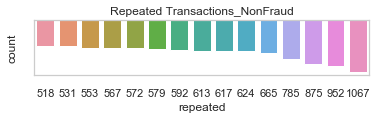

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style('whitegrid')
sns.set_color_codes()

#plt.rcParams["figure.figsize"] = (20,10)
plt.figure(figsize=(15,8))

# mpl.rc('font', family='nanumgothic')
# mpl.rc('axes', unicode_minus=False)

current_palette = sns.color_palette()
sns.palplot(sns.color_palette("Blues"))

sns.countplot(x="repeated", data=n)
plt.title("Repeated Transactions_NonFraud")
plt.show()

In [1]:
t

NameError: name 't' is not defined